# Sedimentation Rate Analysis

### Load dataset and declare indices of variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import geo_preprocess3
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

% matplotlib inline

# load data
data = np.genfromtxt('alldata_new_decomp', delimiter='')

# define column index for 19 variables
lon_ind = 0
lat_ind = 1
sedthick_ind = 2
sedrate_ind = 3   
age_ind = 4
passive_dis_ind = 5
amazon_dis_ind = 6
congo_dis_ind = 7
gange_dis_ind = 8
godava_dis_ind = 9
indus_dis_ind = 10
magdalena_dis_ind = 11
mahan_dis_ind = 12
missi_dis_ind = 13
narma_dis_ind = 14
niger_dis_ind = 15
orin_dis_ind = 16
paleo_dis_ind = 17
parana_dis_ind = 18

river_indices = np.array([amazon_dis_ind, congo_dis_ind, gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          orin_dis_ind, paleo_dis_ind, parana_dis_ind])

river_names = np.array(['Amazon', 'Congo', 'Ganges-Bramaputra', 'Godavari-Krishna', 'Indus',
                        'Magdalena', 'Mahanadi', 'Mississipi', 'Narma', 'Niger', 'Orinoco',
                        'Paleo-Congo', 'Parana'])

print(river_indices)
data.shape

[ 6  7  8  9 10 11 12 13 14 15 16 17 18]


(29765, 19)

### Declare the regressor 

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# number of splits for LongFold cross validation
n_splits = 3

# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

### Remove records where rate is nan, age is nan, and distance to passive is nan

In [3]:
# remove records where thick is zero
y = data[:, sedthick_ind]
data = data[~(y == 0)]

# remove records where age is nan
y = data[:, age_ind]
data = data[~np.isnan(y)]

# remove records where distance to passive margin is nan
y = data[:, passive_dis_ind]
data = data[~np.isnan(y)]

# remove records where sediment rate is nan or 0
sedrate = data[:, sedrate_ind]
index = (~np.isnan(sedrate)) & (~(sedrate == 0))
data = data[index]

# the final dataset has dimension as follows
data.shape

(27299, 19)

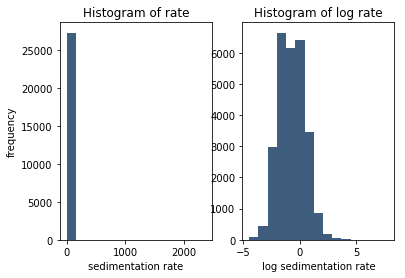

In [4]:
# plot histogram for sedimentation rate and log sedimentation rate
f, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(data[:, [sedrate_ind]], color="#3F5D7D", bins=15)
ax2.hist(np.log(data[:, [sedrate_ind]]), color="#3F5D7D", bins=15)
ax1.set_xlabel('sedimentation rate')
ax1.set_ylabel('frequency')
ax2.set_xlabel('log sedimentation rate')
ax1.set_title('Histogram of rate')
ax2.set_title('Histogram of log rate')
plt.show()

### Define helper functions

In [14]:
def generate_irivers(data, river_indices):
    """Generate inverse of selected rivers from given data."""
    
    rivers = data[:, river_indices]
    
    # mask rivers with distance greater than 1500km
    rivers[rivers > 1500.0] = np.nan

    rivers[np.isnan(rivers)] = np.inf
    
    return 1.0 / rivers


def plot_goodness_fit(lon, lat, yactual, ypred, ypred_no_rivers, time):
    """Generate various plots of goodness of fit."""
    # scatterplot of ypred and yactual
    geo_preprocess3.feature_scatter(yactual, ypred, 
                                    title = 'Fit with rivers ' + time,
                                   xlim1=-4,
                                   xlim2=3,
                                   ylim1=-4,
                                   ylim2=3)
    # scatterplot of ypred_no_rivers and yactual
    geo_preprocess3.feature_scatter(yactual, ypred_no_rivers, 
                                    title = 'Fit without rivers ' + time,
                                   xlim1=-4,
                                   xlim2=3,
                                   ylim1=-4,
                                   ylim2=3)

    # global map of y actual
    geo_preprocess3.draw_global(c=yactual, 
                                title='actual log sediment rate ' + time,
                                longitude=lon, latitude=lat, 
                                vmin=-4, 
                                vmax=3)
    
    # global map of y predicted
    geo_preprocess3.draw_global(c=ypred, 
                           title='predicted log sediment rate with rivers ' + time,
                           longitude=lon, latitude=lat, 
                           vmin=-4, 
                           vmax=3)

    # global map of y predicted without rivers
    geo_preprocess3.draw_global(c=ypred_no_rivers, 
                           title='predicted log sediment rate without rivers ' + time,
                           longitude=lon, latitude=lat, 
                           vmin=-4, 
                           vmax=3)

    # ypred - ypred_no_rivers
    geo_preprocess3.draw_global(c= (np.exp(ypred) - np.exp(ypred_no_rivers)), 
                       title='predicted rate with rivers minus predicted rate without rivers ' + time,
                       longitude=lon, latitude=lat, 
                       vmin=-2, 
                       vmax=2)

### Train and Predict - with all rivers

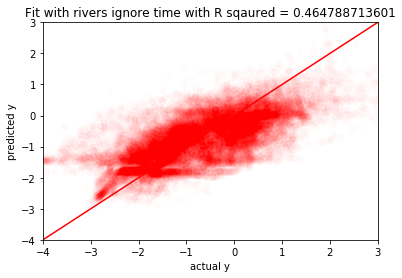

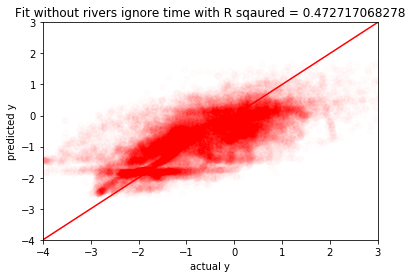

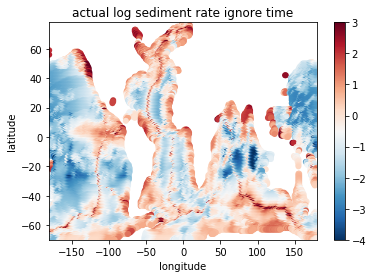

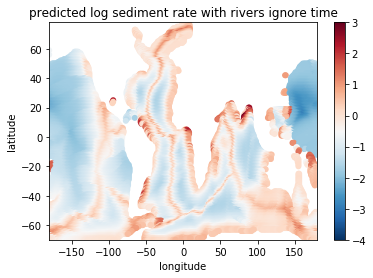

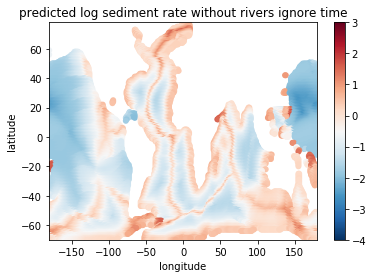

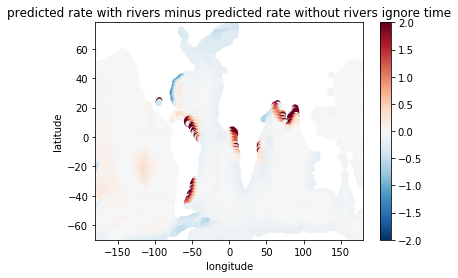

In [15]:
np.seterr(invalid='ignore')

irivers = generate_irivers(data, river_indices)

# data1 only has feature longitude, latitude, age and distance to passive margin
data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]

# extract sedimentation rate
sedrate = data[:, sedrate_ind]

def compute_r2(weights):
    nr2 = 0.0
    
    # square weights to make sure they are positive
    weights = weights ** 2

    # obtain weighted sum of inverse of distance to rivers
    ws_river = np.sum(irivers * weights, axis=1)
    
    # integrate all features and target variable into one matrix - data2
    data2 = np.c_[data1, ws_river, sedrate]
    
    # do regression 
    # - this is a function in file geo_preprocess3
    # - it use longitude to do LongFold cross validation
    # - logy=True means apply log transform to target variable y
    ypred,_ = geo_preprocess3.regression(data=data2, 
                    regressor=regressor, 
                    n_splits=n_splits,
                    lon_ind=lon_ind, 
                    lat_ind=lat_ind, 
                    y_ind=-1,
                    logy=True)
    
    yactual = np.log(sedrate)
    
    # obtain negative r square of actual log rate and predicted log rate
    nr2 = -1.0 * r2_score(yactual, ypred)
    
    # print nr2 to see the process of optimization
    print(nr2)
    return nr2



# initial guess of weights; seed fix random number so that we can recover the result
np.random.seed(0)
w0 = np.random.random(13)

# here I comment out the command for launching optmization, it takes long time to converge

# res = minimize(fun=compute_r2,
#                x0=w0,
#                method='COBYLA',
#                tol=1e-6,
#                options={'maxiter': 10000,
#                         'disp': True}
# )
# res.x
# opt = res.x
# opt_weights = opt ** 2
# print(tabulate(np.vstack([river_names, opt_weights]).T))


# This is the optimal weights from optimization
opt_weights = np.array([
        0.82880631,
        0.17390902,
        0.35638273,
        0.36284359,
        0.03679376,
        0.02927179,
        0.29118327,
        0.68002453,
        1.34912871,
        0.178907,
        0.32999625,
        0.08140008,
        0.60066065
    ])

# use opt_weights to get optimal weighted sum of inverse of distance to rivers
ws_river = np.sum(irivers * opt_weights, 1)

# re-define data2 with optimal weighted summation
data2 = np.c_[data1, ws_river, sedrate]

# regression, with optimal weighted sum of inverse of distance to rivers
# return predicted log rate and trained regressor
ypred, _ =  geo_preprocess3.regression(data=data2, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)

# regression, without distance to river features
# remove data points with distance less than 1500km
indices_remain = np.any(irivers == 0, 1)
data2_no_rivers = np.c_[data1[indices_remain], sedrate[indices_remain]]

# train regressor given dataset with data points whose distance less than 1500 removed
_, regressor_trained =  geo_preprocess3.regression(data=data2_no_rivers, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)
# predict y given all data points
ypred_no_rivers = geo_preprocess3.predict(data1, regressor_trained, lon_ind=lon_ind,
                                         lat_ind=lat_ind)

# extract longitude, latitude and sedrate for plots
lon = data1[:,lon_ind]
lat = data1[:,lat_ind]
yactual = np.log(sedrate)

# generate various plots of goodness of fit
plot_goodness_fit(lon, lat, yactual, ypred, ypred_no_rivers, 'ignore time')

### Train and Predict - Present (exclude Paleo-Congo)

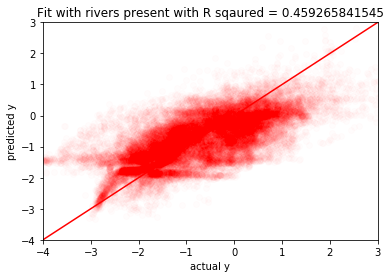

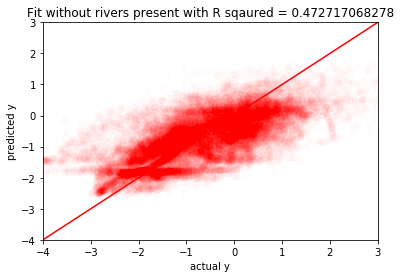

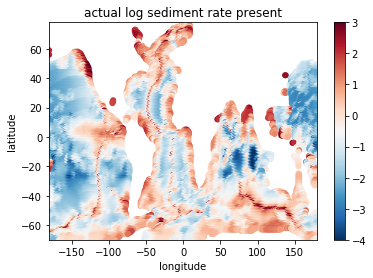

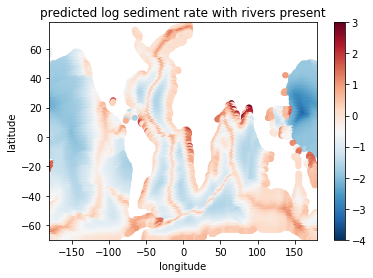

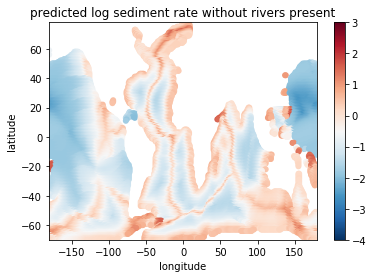

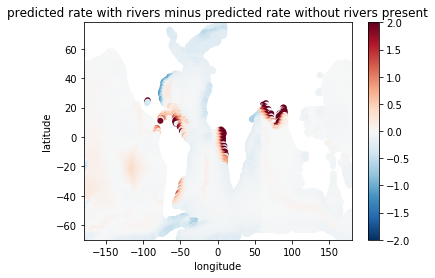

In [16]:
age = data[:, age_ind]

# existed river indices
c_river_indices = np.array([amazon_dis_ind, congo_dis_ind, gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          orin_dis_ind, parana_dis_ind])

# extract subset of data so that the age is greater than 0.0
period_index = (age > 0.0)
datapd = data[period_index]

# generate inverse of rivers
irivers = generate_irivers(datapd, c_river_indices)

# data1 only has feature longitude, latitude, age and distance to passive margin
data1 = datapd[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]

# extract sedimentation rate
sedrate = datapd[:, sedrate_ind]

def compute_r2(weights):
    nr2 = 0.0
    weights = weights ** 2
    ws_river = np.sum(irivers * weights, axis=1)
    data2 = np.c_[data1, ws_river, sedrate]
    ypred,_ = geo_preprocess3.regression(data=data2, 
                    regressor=regressor, 
                    n_splits=n_splits,
                    lon_ind=lon_ind, 
                    lat_ind=lat_ind, 
                    y_ind=-1,
                    logy=True)
    
    yactual = np.log(sedrate)
    nr2 = -1.0 * r2_score(yactual, ypred)
    print(nr2)
    return nr2

# initial guess of weights; seed fix random number so that we can recover the result
np.random.seed(0)
w0 = np.random.random(len(c_river_indices))

# here I comment out the command for launching optmization, it takes long time to converge

# res = minimize(fun=compute_r2,
#                x0=w0,
#                method='COBYLA',
#                tol=1e-6,
#                options={'maxiter': 10000,
#                         'disp': True}
# )
# res.x
# opt = res.x
# opt_weights = opt ** 2
# print(tabulate(np.vstack([river_names[c_river_indices - 6], opt]).T))


# This is the optimal weights from optimization
opt_weights = np.array([
        0.23177196,
        0.37932296,
        3.23755246,
        0.49370859,
        0.3206787,
        0.44191118,
        0.25530889,
        0.74211505,
        0.5854683,
        0.11142845,
        0.45804064,
        0.28009498
    ])

# use opt_weights to get optimal weighted sum of inverse of distance to rivers
ws_river = np.sum(irivers * opt_weights, 1)

# re-define data2 with optimal weighted summation
data2 = np.c_[data1, ws_river, sedrate]

# regression, with optimal weighted sum of inverse of distance to rivers
# return predicted log rate and trained regressor
ypred, _ =  geo_preprocess3.regression(data=data2, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)

# regression, without distance to river features
# remove data points with distance less than 1500km
indices_remain = np.any(irivers == 0, 1)
data2_no_rivers = np.c_[data1[indices_remain], sedrate[indices_remain]]

# train regressor given dataset with data points whose distance less than 1500 removed
_, regressor_trained =  geo_preprocess3.regression(data=data2_no_rivers, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)
# predict y given all data points
ypred_no_rivers = geo_preprocess3.predict(data1, regressor_trained, lon_ind=lon_ind,
                                         lat_ind=lat_ind)

# extract longitude, latitude and sedrate for plots
lon = data1[:,lon_ind]
lat = data1[:,lat_ind]
yactual = np.log(sedrate)

# generate various plots of goodness of fit
plot_goodness_fit(lon, lat, yactual, ypred, ypred_no_rivers, 'present')

### Train and Predict - 26Ma (exclude Paleo-Congo)

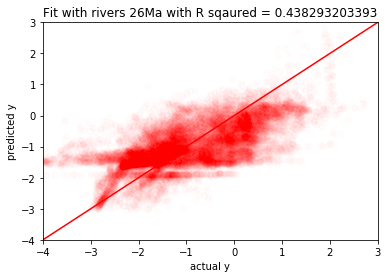

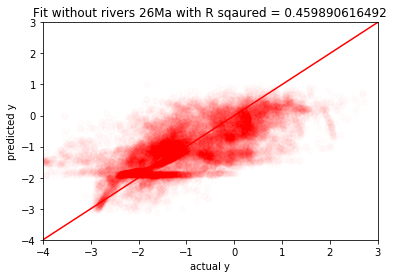

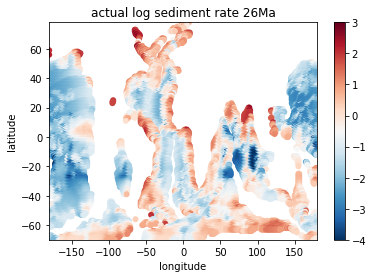

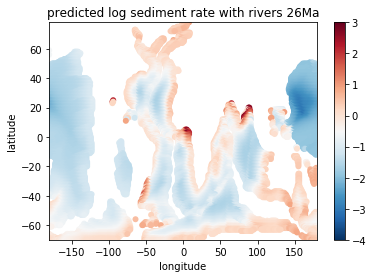

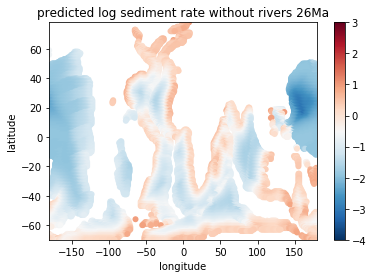

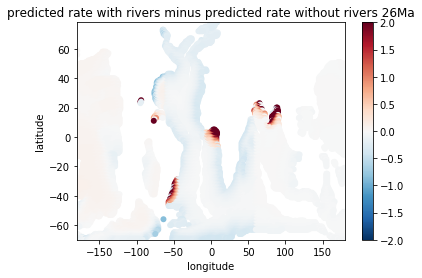

In [17]:
# existed river indices
c_river_indices = np.array([gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          parana_dis_ind])

# extract subset of data so that the age is greater than 26.0
period_index = (age > 26.0)
datapd = data[period_index]

# generate inverse of rivers
irivers = generate_irivers(datapd, c_river_indices)

# data1 only has feature longitude, latitude, age and distance to passive margin
data1 = datapd[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]

# extract sedimentation rate
sedrate = datapd[:, sedrate_ind]

def compute_r2(weights):
    nr2 = 0.0
    weights = weights ** 2
    ws_river = np.sum(irivers * weights, axis=1)
    data2 = np.c_[data1, ws_river, sedrate]
    ypred,_ = geo_preprocess3.regression(data=data2, 
                    regressor=regressor, 
                    n_splits=n_splits,
                    lon_ind=lon_ind, 
                    lat_ind=lat_ind, 
                    y_ind=-1,
                    logy=True)
    
    yactual = np.log(sedrate)
    nr2 = -1.0 * r2_score(yactual, ypred)
    print(nr2)
    return nr2

# initial guess of weights; seed fix random number so that we can recover the result
np.random.seed(0)
w0 = np.random.random(len(c_river_indices))

# here I comment out the command for launching optmization, it takes long time to converge

# res = minimize(fun=compute_r2,
#                x0=w0,
#                method='COBYLA',
#                tol=1e-6,
#                options={'maxiter': 10000,
#                         'disp': True}
# )
# res.x
# opt = res.x
# opt_weights = opt ** 2
# print(tabulate(np.vstack([river_names[c_river_indices - 6], opt_weights]).T))

# This is the optimal weights from optimization
opt_weights = np.array([
        0.519334,
        0.943441,
        0.943441,
        0.77053,
        0.944752,
        2.15442,
        0.329905,
        0.86657,
        1.51828
    ])

# use opt_weights to get optimal weighted sum of inverse of distance to rivers
ws_river = np.sum(irivers * opt_weights, 1)

# re-define data2 with optimal weighted summation
data2 = np.c_[data1, ws_river, sedrate]

# regression, with optimal weighted sum of inverse of distance to rivers
# return predicted log rate and trained regressor
ypred, _ =  geo_preprocess3.regression(data=data2, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)

# regression, without distance to river features
# remove data points with distance less than 1500km
indices_remain = np.any(irivers == 0, 1)
data2_no_rivers = np.c_[data1[indices_remain], sedrate[indices_remain]]

# train regressor given dataset with data points whose distance less than 1500 removed
_, regressor_trained =  geo_preprocess3.regression(data=data2_no_rivers, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)
# predict y given all data points
ypred_no_rivers = geo_preprocess3.predict(data1, regressor_trained, lon_ind=lon_ind,
                                         lat_ind=lat_ind)

# extract longitude, latitude and sedrate for plots
lon = data1[:,lon_ind]
lat = data1[:,lat_ind]
yactual = np.log(sedrate)

# generate various plots of goodness of fit
plot_goodness_fit(lon, lat, yactual, ypred, ypred_no_rivers, '26Ma')

### Train and Predict - 56Ma (only Parana, Paleo-Congo, Niger)

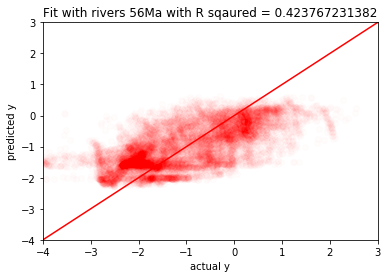

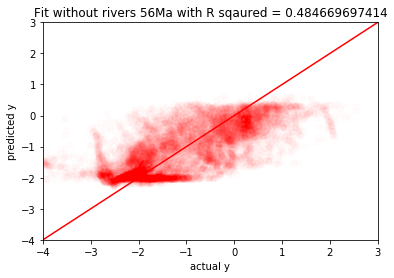

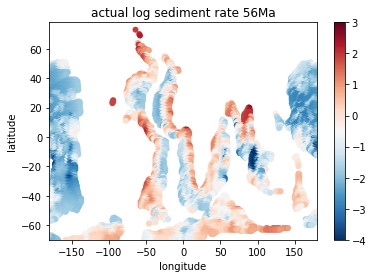

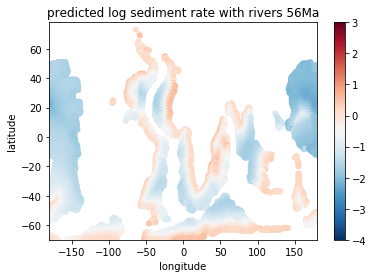

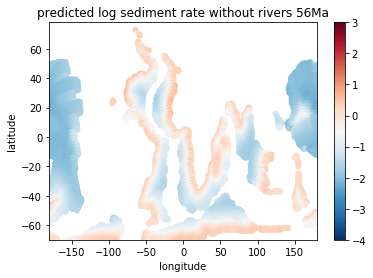

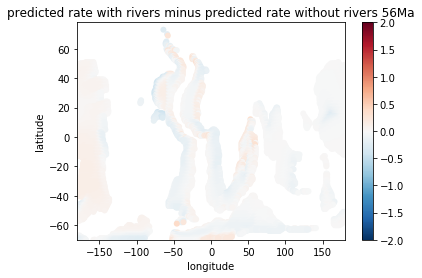

In [18]:
# existed river indices
c_river_indices = np.array([niger_dis_ind,paleo_dis_ind, parana_dis_ind])


# extract subset of data so that the age is greater than 26.0
period_index = (age > 56.0)
datapd = data[period_index]

# generate inverse of rivers
irivers = generate_irivers(datapd, c_river_indices)

# data1 only has feature longitude, latitude, age and distance to passive margin
data1 = datapd[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]

# extract sedimentation rate
sedrate = datapd[:, sedrate_ind]

def compute_r2(weights):
    nr2 = 0.0
    weights = weights ** 2
    ws_river = np.sum(irivers * weights, axis=1)
    data2 = np.c_[data1, ws_river, sedrate]
    ypred,_ = geo_preprocess3.regression(data=data2, 
                    regressor=regressor, 
                    n_splits=n_splits,
                    lon_ind=lon_ind, 
                    lat_ind=lat_ind, 
                    y_ind=-1,
                    logy=True)
    
    yactual = np.log(sedrate)
    nr2 = -1.0 * r2_score(yactual, ypred)
    print(nr2)
    return nr2

# initial guess of weights; seed fix random number so that we can recover the result
np.random.seed(0)
w0 = np.random.random(len(c_river_indices))

# here I comment out the command for launching optmization, it takes long time to converge

# res = minimize(fun=compute_r2,
#                x0=w0,
#                method='COBYLA',
#                tol=1e-6,
#                options={'maxiter': 10000,
#                         'disp': True}
# )
# res.x
# opt = res.x
# opt_weights = opt ** 2
# print(tabulate(np.vstack([river_names[c_river_indices - 6], opt_weights]).T))



# This is the optimal weights from optimization
opt_weights = np.array([
        0.927084,
        0.000577668,
        3.88235
    ])

# use opt_weights to get optimal weighted sum of inverse of distance to rivers
ws_river = np.sum(irivers * opt_weights, 1)

# re-define data2 with optimal weighted summation
data2 = np.c_[data1, ws_river, sedrate]

# regression, with optimal weighted sum of inverse of distance to rivers
# return predicted log rate and trained regressor
ypred, _ =  geo_preprocess3.regression(data=data2, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)

# regression, without distance to river features
# remove data points with distance less than 1500km
indices_remain = np.any(irivers == 0, 1)
data2_no_rivers = np.c_[data1[indices_remain], sedrate[indices_remain]]

# train regressor given dataset with data points whose distance less than 1500 removed
_, regressor_trained =  geo_preprocess3.regression(data=data2_no_rivers, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)
# predict y given all data points
ypred_no_rivers = geo_preprocess3.predict(data1, regressor_trained, lon_ind=lon_ind,
                                         lat_ind=lat_ind)

# extract longitude, latitude and sedrate for plots
lon = data1[:,lon_ind]
lat = data1[:,lat_ind]
yactual = np.log(sedrate)

# generate various plots of goodness of fit
plot_goodness_fit(lon, lat, yactual, ypred, ypred_no_rivers, '56Ma')

### Feature Analysis - Age

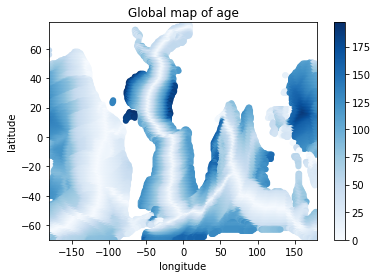

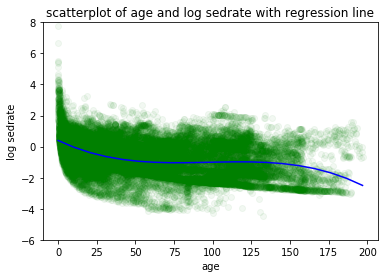

In [10]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of age
age = data[:, age_ind]
sedrate = data[:, sedrate_ind]
geo_preprocess3.draw_global(c=age, 
                            title='Global map of age',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=197, 
                            cmap='Blues')

# learn relationship between age and sedrate
regressor.fit(age.reshape(-1,1), np.log(sedrate))
fea_min = np.min(age)
fea_max = np.max(age)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of age and log sedrate
plt.plot(age, np.log(data[:, sedrate_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of age and log sedrate with regression line')
plt.xlabel('age')
plt.ylabel('log sedrate')
plt.ylim([-6, 8])
plt.show()

### Feature Analysis - Distance to passive margin

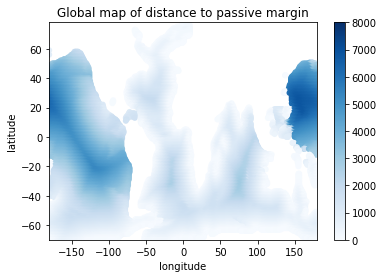

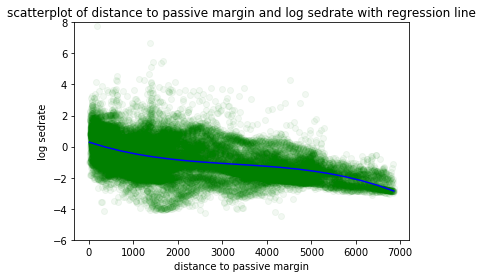

In [11]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of distance to passive margine
passive_dis = data[:, passive_dis_ind]
sedrate = data[:, sedrate_ind]
geo_preprocess3.draw_global(c=passive_dis, 
                            title='Global map of distance to passive margin',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=8000,
                            cmap='Blues')

# learn relationship between distance to passive margine and sedrate
regressor.fit(passive_dis.reshape(-1,1), np.log(sedrate))
fea_min = np.min(passive_dis)
fea_max = np.max(passive_dis)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of distance to passive margine and log sedrate
plt.plot(passive_dis, np.log(data[:, sedrate_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of distance to passive margin and log sedrate with regression line')
plt.xlabel('distance to passive margin')
plt.ylabel('log sedrate')
plt.ylim([-6, 8])
plt.show()